In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
munro = pd.read_csv('datasets/clean.csv')
munro.head()

,name,altitude,ascent_count,rating,region,report_count,rating_count,bb_count,hotel_count,hostel_count,...,neighbor_count_10,neighbor_count_15,neighbor_count_20,nearest_city_dist,nearest_city_population,nearest_large_city_dist,population_25,population_50,population_75,population_100
0,Ben Nevis,1345,17902,3.84,Fort William,316,253,72,41,18,...,16,20,29,6.68,10459,89.19,10459,10459,19034,242223
1,Ben Macdui,1309,10449,3.78,Cairngorms,215,162,37,29,9,...,14,17,20,56.26,70000,56.26,0,0,158093,762982
2,Braeriach,1296,6035,3.95,Cairngorms,141,94,37,29,9,...,12,16,20,53.49,70000,53.49,0,0,150894,762982
3,Cairn Toul,1291,5121,3.86,Cairngorms,136,83,37,29,9,...,14,18,21,56.30,70000,56.30,0,0,205053,771982
4,Sgor an Lochain Uaine,1258,4832,3.83,Cairngorms,139,79,37,29,9,...,13,18,20,55.43,70000,55.43,0,0,158093,771982


In [3]:
relevant_cols = [ 'altitude','rating_count','bb_count','hostel_count','cottage_count','camping_count', 
    'neighbor_count_1', 'neighbor_count_2.5', 'neighbor_count_5', 'neighbor_count_10', 'neighbor_count_15',
    'neighbor_count_20', 'nearest_city_dist', 'nearest_city_population', 'nearest_large_city_dist', 
    'population_25', 'population_50', 'population_75', 'population_100']
munro_subset = munro[relevant_cols]
munro_subset.head()

,altitude,rating_count,bb_count,hostel_count,cottage_count,camping_count,neighbor_count_1,neighbor_count_2.5,neighbor_count_5,neighbor_count_10,neighbor_count_15,neighbor_count_20,nearest_city_dist,nearest_city_population,nearest_large_city_dist,population_25,population_50,population_75,population_100
0,1345,253,72,18,147,147,0,1,5,16,20,29,6.68,10459,89.19,10459,10459,19034,242223
1,1309,162,37,9,182,182,0,0,7,14,17,20,56.26,70000,56.26,0,0,158093,762982
2,1296,94,37,9,182,182,0,1,3,12,16,20,53.49,70000,53.49,0,0,150894,762982
3,1291,83,37,9,182,182,0,2,6,14,18,21,56.30,70000,56.30,0,0,205053,771982
4,1258,79,37,9,182,182,0,2,6,13,18,20,55.43,70000,55.43,0,0,158093,771982


## Data scaling

In [4]:
scaler = StandardScaler()
scaled_munro = pd.DataFrame(scaler.fit_transform(munro_subset), index = munro_subset.index, columns = munro_subset.columns)

## PCA

In [5]:
pca = PCA().fit(scaled_munro)
eigenvalue = (pca.explained_variance_)

### Scree plot

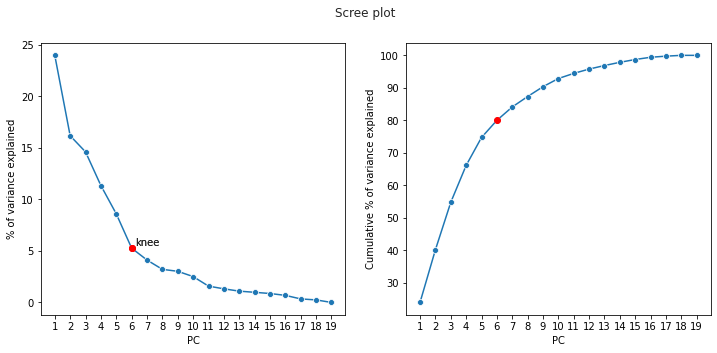

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
y = pca.explained_variance_ratio_ * 100
x = range(1, len(y)+1)

sns.set_style("ticks")

# Scree plot (ax1)
sns.lineplot(x=x, y=y, marker='o', ax=ax1)
ax1.set_ylabel('% of variance explained')
ax1.set_xticks(x)
ax1.set_xlabel('PC')
# Mark the knee
knee = 6
ax1.plot(knee, y[knee-1], color='red', marker='o', label='knee')
ax1.annotate('knee', (knee + 0.2, y[knee-1] + 0.2))

# Cumulative scree plot (ax2)
y2 = y.cumsum()
sns.lineplot(x=x, y=y2, marker='o', ax=ax2)
ax2.set_ylabel('Cumulative % of variance explained')
ax2.set_xticks(x)
ax2.set_xlabel('PC')

# Mark the knee
knee = 6
ax1.plot(knee, y[knee-1], color='red', marker='o', label='knee')
ax1.annotate('knee', (knee + 0.2, y[knee-1] + 0.2))
ax2.plot(knee, y2[knee-1], color='red', marker='o')

plt.suptitle('Scree plot')
plt.show()

- The scree plot shows that the first 6 principal components help explain a considerable amount of variance. The knee is indicated in red. 
- Using the cumulative plot, we see that the first 6 PCs explain 80% of the variance in the data.
- We now reaplly PCA, keeping only the first 6 components.

### PCA with fewer components

In [7]:
pca = PCA(n_components=knee)
transformed_values = pca.fit_transform(scaled_munro)

In [8]:
pc_scores = [f'PC{i+1}' for i in range(knee)]

# Styling
def highlight_max(s):
    def _highlight(val):
        if abs(val) in max_:
            if val >= 0:
                return 'background-color: green'
            else:
                return 'background-color: orange'
        return ''
    max_ = s.abs().nlargest(10).values
    return [_highlight(v) for v in s]

# Dump components relations with features:
pd.DataFrame(pca.components_, columns=scaled_munro.columns, index=pc_scores).T.style.apply(highlight_max)

,PC1,PC2,PC3,PC4,PC5,PC6
altitude,-0.110933,0.100956,-0.083057,-0.008001,0.481474,-0.067495
rating_count,0.225023,0.283883,-0.001603,0.271060,0.199524,-0.012226
bb_count,-0.158850,0.423489,0.089981,-0.069245,-0.166513,-0.292518
hostel_count,-0.275409,0.370651,0.100302,-0.146396,-0.161042,0.012400
cottage_count,-0.270215,0.235291,0.329948,-0.075523,0.208076,-0.061538
camping_count,-0.270215,0.235291,0.329948,-0.075523,0.208076,-0.061538
neighbor_count_1,-0.179908,-0.125923,0.235749,0.432556,-0.119859,-0.018641
neighbor_count_2.5,-0.233412,-0.085513,0.058591,0.475537,-0.020890,0.121615
neighbor_count_5,-0.298916,-0.097384,-0.081706,0.396719,0.131805,0.021538
neighbor_count_10,-0.315015,-0.065207,-0.331948,0.115718,0.196226,0.031312


In [9]:
# PC1 = "remoteness" - number of accom. facilities, neighboring munros and proximity to a large city have a large negative effect
# PC2 = "civilisation" - positive effect: number of accom. facilities, rating, proximity to cities
# PC3 = "compactness / ...aww" - positive effect: number of accom. facilities, number of munros within 1km, distance to nearest city and its population
# PC4 = " " - 
# PC5 = "mountainousness" - positive effect: altitude, rating_count, cottage/camping (more suitable / affordable for mountaineers?)
# PC6 = 

In [10]:
# TODO: name PC scores
# TODO: add data about regions, county - not PCA, but before we run linear regression

In [11]:
# Source: https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e

def biplot(score, coeff , y):
    '''
    Author: Serafeim Loukas, serafeim.loukas@epfl.ch
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
   '''
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(10,8), dpi=100)
    classes = np.unique(y)
    colors = ['g','r','y']
    markers=['o','^','x']
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l],ys[y==l], c = colors[s], marker=markers[s]) # color based on group
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',fontsize=10)

    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

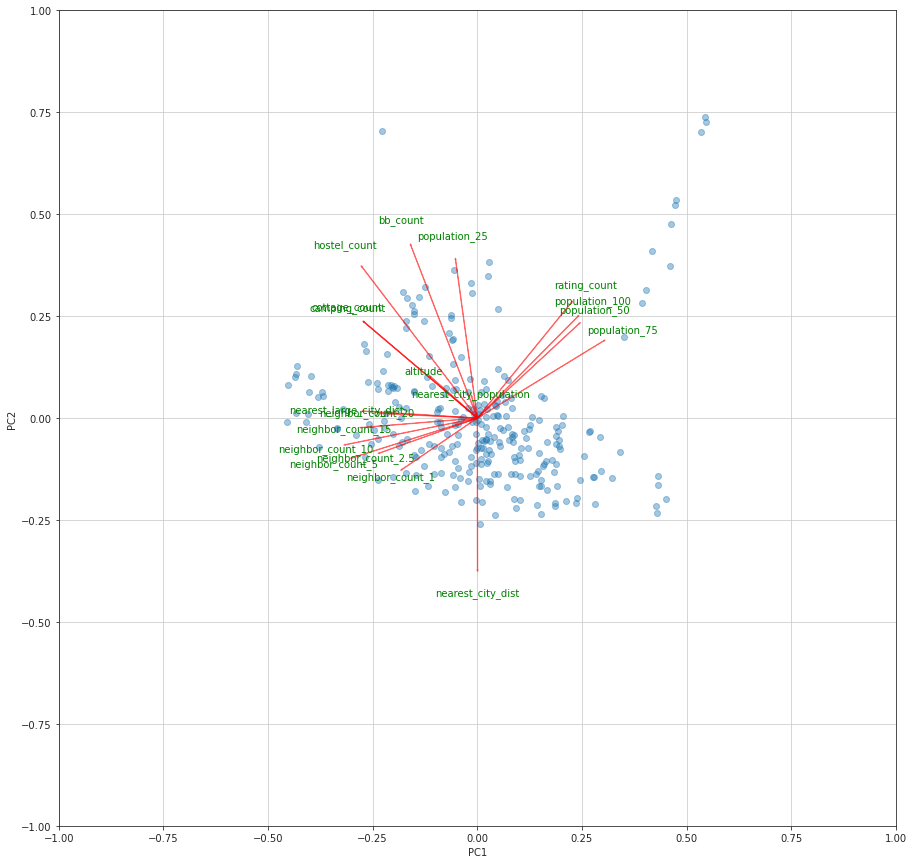

In [12]:
# Adapted from "searlouk"'s post: https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot
def myplot(score,coeff,labels):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.figure(figsize=(15,15))
    plt.scatter(xs * scalex,ys * scaley, alpha=0.4)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.5)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(transformed_values[:,2:4],np.transpose(pca.components_[0:2, :]), labels=munro_subset.columns)
plt.show()

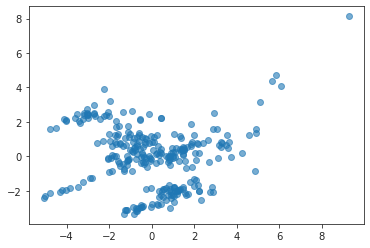

In [13]:
# Plot the first two principal scores
pc1 = transformed_values[:,0]
pc2 = transformed_values[:,1]
plt.scatter(pc1, pc2, alpha=0.6)

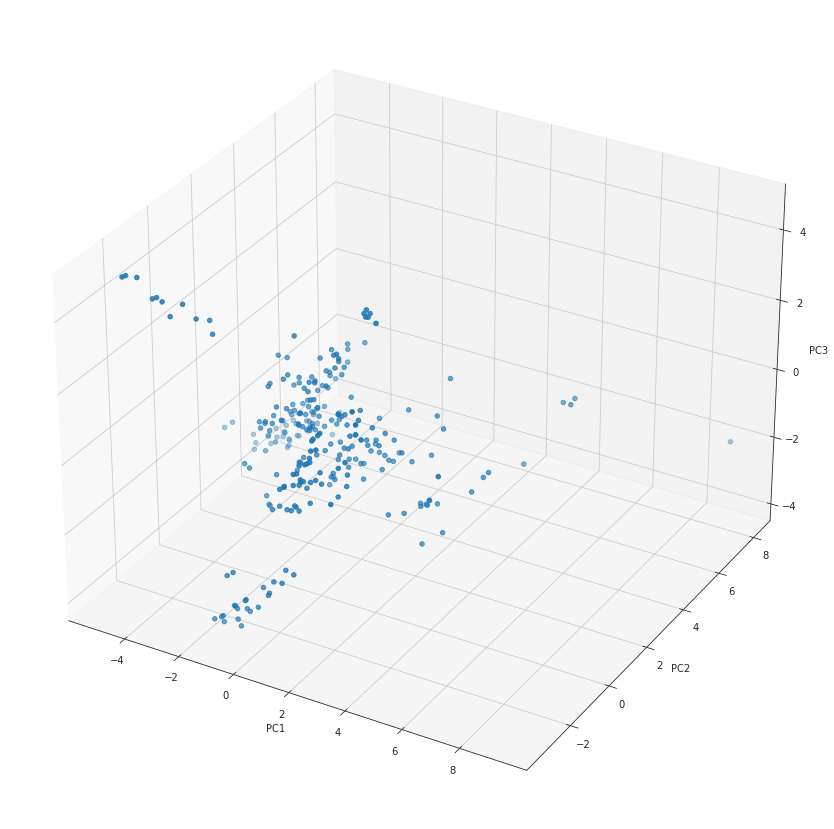

In [15]:
# Plot the first 3 principal scores
pc3 = transformed_values[:,2]

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc1, pc2, pc3)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

## Linear regression

### Without categorical variables

In [16]:
X = pd.DataFrame(transformed_values)
y = munro['ascent_count']
model = sm.OLS(y, X)
results = model.fit()

In [17]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           ascent_count   R-squared (uncentered):                   0.171
Model:                            OLS   Adj. R-squared (uncentered):              0.153
Method:                 Least Squares   F-statistic:                              9.510
Date:                Sat, 27 Mar 2021   Prob (F-statistic):                    1.67e-09
Time:                        14:50:38   Log-Likelihood:                         -2828.8
No. Observations:                 282   AIC:                                      5670.
Df Residuals:                     276   BIC:                                      5691.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------


This clearly performs poorly, so we try adding categorical variables that we could not apply PCA to.

### With categorical variables

In [20]:
categorical_cols = ['region', 'island', 'county']
categorical_one_hot = pd.get_dummies(munro[categorical_cols])

In [21]:
X = pd.concat([pd.DataFrame(transformed_values), categorical_one_hot], axis=1)
y = munro['ascent_count']
model = sm.OLS(y, X)
results = model.fit()

In [22]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ascent_count   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     33.65
Date:                Sat, 27 Mar 2021   Prob (F-statistic):           1.94e-75
Time:                        14:50:51   Log-Likelihood:                -2407.9
No. Observations:                 282   AIC:                             4890.
Df Residuals:                     245   BIC:                             5025.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [23]:
# TODO: Filter out variables with high p-values

In [24]:
irrelevant_cols = [0, 2, 'region_Fort William', 'region_Isle of Skye', 'island_Skye', 'county_Aberdeenshire/Highland', 
    'county_Aberdeenshire/Highland/Perth and Kinross', 'county_Aberdeenshire/Moray', 'county_Argyll and Bute/Perth and Kinross', 
    'county_Argyll and Bute/Highland', 'county_Argyll and Bute/Stirling', 'county_Moray', 'county_Perth and Kinross', 
    'county_Perth and Kinross/Stirling', 'county_Stirling']
relevant_cols = X.columns[~X.columns.isin(irrelevant_cols)]
X_relevant = X[relevant_cols]

In [25]:
# TODO: Test / train split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_relevant, y, test_size=0.2, random_state=42)
model = sm.OLS(y_train, X_train)
results = model.fit()

In [27]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           ascent_count   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              165.4
Date:                Sat, 27 Mar 2021   Prob (F-statistic):                   9.01e-118
Time:                        14:50:53   Log-Likelihood:                         -1940.1
No. Observations:                 225   AIC:                                      3926.
Df Residuals:                     202   BIC:                                      4005.
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [28]:
y_predicted = results.predict(X_test)
sm.tools.eval_measures.rmspe(y_predicted, y_test), sm.tools.eval_measures.rmse(y_predicted, y_test)

(5.120462146339802, 1737.1502953342233)

In [29]:
#  DEFINE PROBLEM!!!!!
# - Can we pick features the way we did?
# - Why is R^2 so high but prediction so shit -> can we do smth about correlation between PCA and categorical indicators?
# - Do we need prediction if it's just descriptive? -> prolly yes
# - Concern: Correlation between PCA scores and categorical variables (not part of PCA)

<AxesSubplot:>

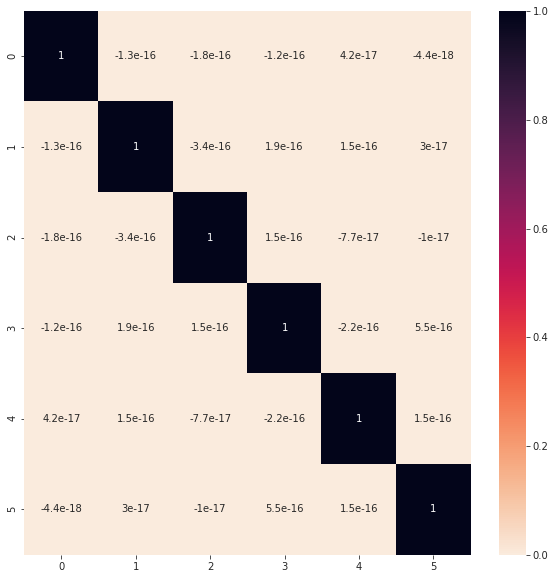

In [31]:
# Sanity check that PCA components are uncorrelateds
pca_data = pd.DataFrame(transformed_values)
plt.figure(figsize=(10,10))
sns.heatmap(pca_data.corr(), annot=True, cmap=sns.cm.rocket_r)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ad6e5521-2329-4ba2-9ce8-c0f71fb15c68' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>